### ДЗ к уроку №2 "Преобразование признаков" курса "ML в бизнесе"

##### Вариант 1)
1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
​
2. Оцените ошибку модели из п.1 .
3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

#### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'svg'

In [2]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Text(0, 0.5, 'МВт')

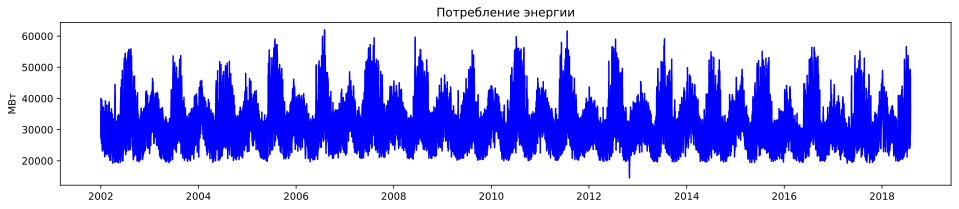

In [3]:
plt.figure(figsize =(16,3))
plt.plot( df.index, df['PJME_MW'], 'b' )
plt.title('Потребление энергии' )
plt.ylabel ( 'МВт' )

In [4]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [5]:
data_exp_1 = exponential_smoothing(df.PJME_MW  , 0.05)

In [6]:
df = pd.DataFrame(data_exp_1, columns=['exponential_smoothing_0.05'], index=df.index)

In [7]:
for i in range(1,4):
    df[f't{i}']=0
    df.iloc[i:,i]=df.iloc[:-i,0].values

In [8]:
def split_data_b(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [9]:
train_b, test_b = split_data_b(df, '01-01-2017')

In [10]:
model = GradientBoostingRegressor(max_depth=7, random_state=0, n_estimators=100)

In [11]:
def predict_model(model, h, train_b, test_b):

    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df.columns[0]].values[h:]

    model.fit(X_train_b, y_train_b)
    X_test_pred = model.predict(X_test_b)
    return X_test_pred, y_test_b

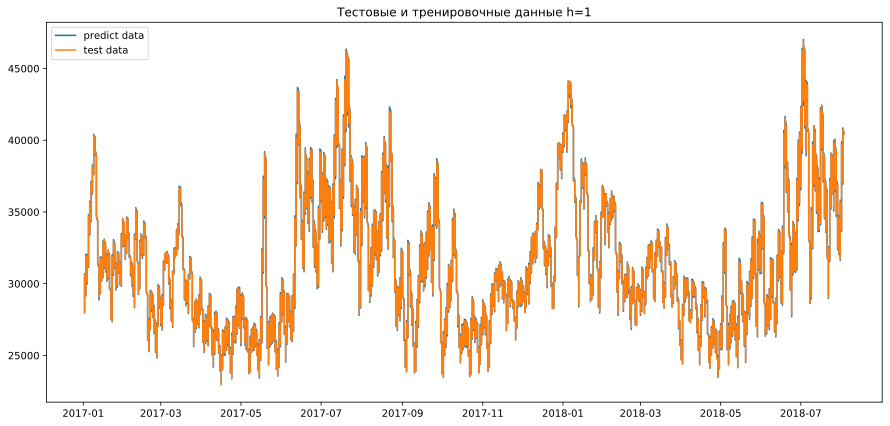

In [12]:
h=1
X_test_pred_h1, y_test_b_h1 = predict_model(model, h, train_b, test_b)

plt.figure(figsize=(15, 7))

plt.plot(test_b.index[h:],X_test_pred_h1, label='predict data')
plt.plot(test_b.index[h:],y_test_b_h1, label='test data')

plt.title(f'Тестовые и тренировочные данные h={h}')
plt.legend()
plt.show()

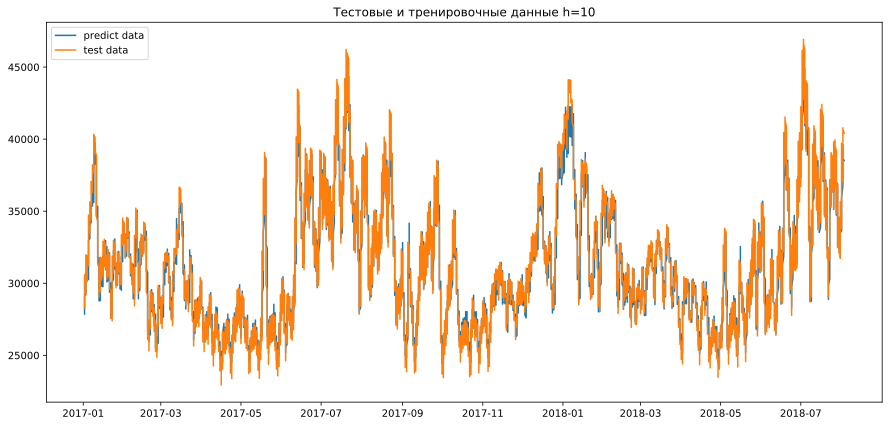

In [13]:
h=10
X_test_pred_h10, y_test_b_h10 = predict_model(model, h, train_b, test_b)

plt.figure(figsize=(15, 7))

plt.plot(test_b.index[h:],X_test_pred_h10, label='predict data')
plt.plot(test_b.index[h:],y_test_b_h10, label='test data')

plt.title(f'Тестовые и тренировочные данные h={h}')
plt.legend()
plt.show()

#### 2.Оцените ошибку модели из п.1 . 

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
print(f'Error h=1: {mean_absolute_percentage_error(y_test_b_h1, X_test_pred_h1):.02f}%')
print(f'Error h=10: {mean_absolute_percentage_error(y_test_b_h10, X_test_pred_h10):.02f}%')

Error h=1: 0.21%
Error h=10: 3.59%


#### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Вывод: При увеличение глубины прогноза, тем сильнее растет ошибка MAE.

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном.

Это нестационарный ряд с трендом на общее (хоть и незначительное) повышение годовых температур, с сезонами (в зависимости от широт) и с смещающимися циклами (ранним или поздним наступлением сезонов времен года; дневными и ночными циклами)

б) Количество денег, которые тратят покупатели в интернет магазине.

Это нестационарный ряд с яркой сезонностью праздничных распродаж с сильным трендом на повышение объемов интернет-торговли 

в) Вес растущего котенка.

Это нестационарный временной ряд с ровным повышательным трендом, заканчивающимся переходом в взрослую особь.

г) Прирост объема деревьев в лесу от времени

Это стационарный ряд, так как речь идёт о взрослом лесе, в котором многолетний (и порой многовековой) жизненный цикл каждого дерева перекрывается жизненным циклом других многочисленных собратьев (если происходят чрезвычайные ситуации (например, пожары))